### Analysis and Insights
By observing both linear regression charts of pre and during covid for total schools against price change, we can see that regardless of the situation or circumstance, home buyers still place an importance in schools being close to their homes. As the number of schools go up, so does the total sales count. It is likely that a large proportion of home buyers make up of people with families, therefore their buying decisions may be contributed by the variety in school choices such as school education levels, government/private schools etc. However, the limitation of this model is that it does not consider LGA sizes. Larger LGAs probably have higher number of suburbs and schools, therefore certainly having more property sales as well. 

Both pre and during covid linear regression models show no correlation between the number of schools and the average sales prices of houses. This means that the change in house prices/value in a particular LGA is not affected by the number of schools in that area, at least not in the short term. Therefore this model is probably not an accurate measurement of suburb/LGA popularity.

In [1]:
# Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
# Read into csv file
schools_csv_file = "./Resources/dv279-schoollocations2019.csv"
schools_df = pd.read_csv(schools_csv_file)

In [3]:
# Drop unwanted columns
to_drop = ["School_Status",
          "Address_Line_1",
          "Address_Line_2",
          "Address_Town",
          "Address_State",
          "Postal_Address_Line_2",
          "Full_Phone_No",
          "Address_Postcode",
          "Postal_State"]

schools_df.drop(columns=to_drop, inplace=True)

# Split LGA Name
schools_df["LGA_Name"] = schools_df.LGA_Name.apply(lambda x: pd.Series(str(x).split(" "))) 

# Capitalise and lower postal town names
schools_df["Postal_Town"] = schools_df.Postal_Town.apply(lambda x: pd.Series(str(x).lower().title()))

# Rename postcode column
schools_df = schools_df.rename(columns={"Postal_Postcode": "Postcode",
                                       "Postal_Town": "Suburb",
                                       "X": "Lat",
                                       "Y": "Lng"})

schools_df.head()

Education_Sector  Entity_Type  School_No  \
0       Government            1          1   
1       Government            1          3   
2       Government            1          4   
3       Government            1          8   
4       Government            1         12   

                              School_Name School_Type Postal_Address_Line_1  \
0                 Alberton Primary School     Primary     21 Thomson Street   
1  Allansford and District Primary School     Primary          Frank Street   
2                    Avoca Primary School     Primary            P O Box 12   
3                   Avenel Primary School     Primary    40 Anderson Street   
4               Warrandyte Primary School     Primary    5-11 Forbes Street   

       Suburb  Postcode  LGA_ID     LGA_Name         Lat        Lng  
0    Alberton      3971     681   Wellington  146.666601 -38.617713  
1  Allansford      3277     673  Warrnambool  142.590393 -38.386281  
2       Avoca      3467     599     Pyrenees  143.475649 -37.084502  
3      Avenel      3664     643  Strathbogie  145.234722 -36.901368  
4  Warrandyte      3113     421   Manningham  145.213980 -37.742675

In [4]:
# Retrieve only the columns we are interested in
suburb_lga_postcode_df = schools_df[["Suburb", "Postcode", "LGA_ID", "LGA_Name"]]

# Drop duplicates
suburb_lga_postcode_df = suburb_lga_postcode_df.drop_duplicates()

# Export into a csv file
suburb_lga_postcode_df.to_csv("./output/suburb_lga_postcode_df.csv", index=False)

In [5]:
# Read into created csv
suburb_lga_postcode = pd.read_csv("./output/suburb_lga_postcode_df.csv")
suburb_lga_postcode

Suburb  Postcode  LGA_ID     LGA_Name
0           Alberton      3971     681   Wellington
1         Allansford      3277     673  Warrnambool
2              Avoca      3467     599     Pyrenees
3             Avenel      3664     643  Strathbogie
4         Warrandyte      3113     421   Manningham
..               ...       ...     ...          ...
983  Truganina South      3029     726      Wyndham
984         Richmond      3121     460    Melbourne
985        Koonwarra      3954      74         Bass
986     Rosebud West      3939     534   Mornington
987          Fitzroy      3065     217    Frankston

[988 rows x 4 columns]

In [6]:
# Groupby suburbs by LGA name
grouped_schools_df = schools_df.groupby(["LGA_Name"])

# Find number of schools in each suburb
schools_count = grouped_schools_df["School_Name"].count()

# Create a new df with school count
schools_count_df = schools_count.reset_index()

# Rename column
schools_count_df = schools_count_df.rename(columns={"School_Name": "School Count"})
schools_count_df.head()

LGA_Name  School Count
0    Alpine            11
1    Ararat            13
2  Ballarat            47
3   Banyule            42
4      Bass            14

In [7]:
# Import percent change in LGA's median housing price file
percent_change_file = ("./Resources/percent_change_perLGA.csv")
percent_change_df = pd.read_csv(percent_change_file)
percent_change_df.head()

LGA_Name  Percent change in house price  Total Sales
0     Banyule                     -11.610266         2285
1     Bayside                      11.899379         2095
2  Boroondara                      -6.213793         2388
3    Brimbank                       1.093687         2251
4    Cardinia                      -1.474852         2173

In [8]:
# Merge school count into percent change per LGA df
merged_lga_school_df = pd.merge(percent_change_df, schools_count_df, on="LGA_Name")
merged_lga_school_df.head()

LGA_Name  Percent change in house price  Total Sales  School Count
0     Banyule                     -11.610266         2285            42
1     Bayside                      11.899379         2095            27
2  Boroondara                      -6.213793         2388            58
3    Brimbank                       1.093687         2251            59
4    Cardinia                      -1.474852         2173            37

In [9]:
# Create a function that calculates z-scores to determine outliers
def zscore_function(df, new_df):

    # Find z-scores using scipy.stats
    z_scores = st.zscore(df)

    # Convert to absolute value with np
    abs_z_scores = np.abs(z_scores)

    # Create boolean array
    filtered_entries = (abs_z_scores < 3).all(axis=1)

    # Assign z-score filtered entries to new df
    new_df = df[filtered_entries]

    return new_df

In [10]:
# Removing outliers in data using z-score
# Only retrieve interested columns
merged_lga_school = merged_lga_school_df[["Percent change in house price", "Total Sales", "School Count"]]

# Run zscore function
new_merged_lga_school = zscore_function(merged_lga_school, "new_merged_lga_school")

# Adding LGA_Name column to new df
new_merged_lga_school["LGA_Name"] = merged_lga_school_df["LGA_Name"]

# Rearrange columns
new_merged_lga_school = new_merged_lga_school[["LGA_Name", "Percent change in house price", "Total Sales", "School Count"]]
new_merged_lga_school.head()

LGA_Name  Percent change in house price  Total Sales  School Count
0     Banyule                     -11.610266         2285            42
1     Bayside                      11.899379         2095            27
2  Boroondara                      -6.213793         2388            58
3    Brimbank                       1.093687         2251            59
4    Cardinia                      -1.474852         2173            37

In [11]:
# Linear regression function
def create_linear_regression_plot(x_values, y_values, x_label, y_label, months, period, line_placement, ylim=None):
    (slope, intercept, rvalue, pvalue, stderr) = st.linregress(x_values, y_values)
    
    # Get regression values
    regress_values = x_values * slope + intercept
    
    # Create line equation string
    line_eq = "y = " + str(round(slope,2)) + "x +" + str(round(intercept, 2))
    
    # Using pyplot to create scatter plot
    plt.scatter(x_values, y_values)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    if ylim != None:
        plt.ylim = (0, ylim)
    plt.title(f'{months} ({period} covid) - {x_label} vs. {y_label}')
    plt.annotate(line_eq,line_placement,fontsize=15,color="red")
    plt.grid(which="major", axis="both")
    
    # Print r-squared value
    print(f"The r-squared is: {rvalue**2}")
    
    # Print correlation between both factors
    correlation = st.pearsonr(x_values,y_values)
    print(f"The correlation between both factors is {round(correlation[0],2)}")
    
    # Save linear regression plot as png file
    plt.savefig(f"./output/{period}-covid_{x_label}_vs_{y_label}.png")
    
    return plt.plot(x_values,regress_values,"r-")

The r-squared is: 0.006642784905242097
The correlation between both factors is -0.08


[&lt;matplotlib.lines.Line2D at 0x235ace01940&gt;]

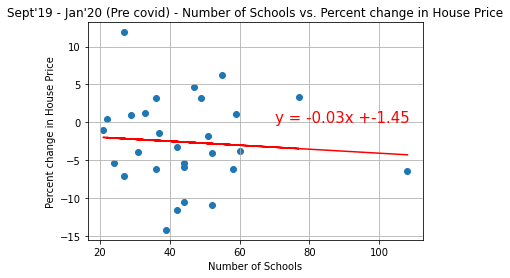

In [12]:
x_values = new_merged_lga_school["School Count"]
y_values = new_merged_lga_school["Percent change in house price"]
create_linear_regression_plot(x_values, y_values, "Number of Schools", "Percent change in House Price", "Sept'19 - Jan'20", "Pre", (70,0), ylim=None)

The linear regression model above shows no correlation between the number of schools and the percent change in median house price. This means that the change in house prices/value in a particular LGA is not affected by the number of schools in that area. It is worth mentioning that most of the data points are clustered in the 20 to 60 schools per LGA

The r-squared is: 0.4010216691230963
The correlation between both factors is 0.63


[&lt;matplotlib.lines.Line2D at 0x235b3bed2b0&gt;]

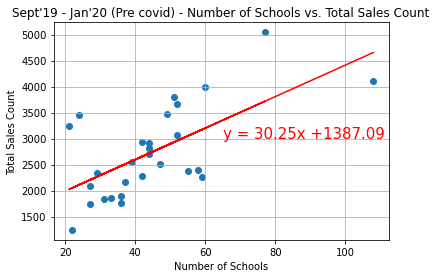

In [13]:
x_values = new_merged_lga_school["School Count"]
y_values = new_merged_lga_school["Total Sales"]
create_linear_regression_plot(x_values, y_values, "Number of Schools", "Total Sales Count", "Sept'19 - Jan'20", "Pre", (65,3000), ylim=None)

The linear regression model above shows a moderate positive correlation between the number of schools and the total sales count. This means that the higher the number of schools in any given LGA, there is a considerably higher total sales count for that LGA. It is safe to assume that before COVID-19 there are a considerable number of buyers whose buying decisions are driven by the proximity of schools within their residence. However, this is also likely due to the different sizes of LGAs.

In [14]:
# Import victorian sales during covid
sales_covid_file = ("./Resources/vic-sales-postcovid.csv")
sales_covid_df = pd.read_csv(sales_covid_file)
sales_covid_df

Unnamed: 0   date_sold      price        suburb  city_name state  \
0           80882  2020-02-01   485000.0     Melbourne  Melbourne   VIC   
1           80883  2020-02-01   485000.0     Melbourne  Melbourne   VIC   
2           80884  2020-02-01   446500.0     Melbourne  Melbourne   VIC   
3           80885  2020-02-01   446500.0     Melbourne  Melbourne   VIC   
4           80886  2020-02-01   420000.0       Clayton  Melbourne   VIC   
...           ...         ...        ...           ...        ...   ...   
22325      103207  2020-07-16  1730000.0     Beaumaris  Melbourne   VIC   
22326      103208  2020-07-16  1100000.0        Altona  Melbourne   VIC   
22327      103209  2020-07-16   790000.0  Beaconsfield  Melbourne   VIC   
22328      103210  2020-07-16   335000.0     Doncaster  Melbourne   VIC   
22329      103211  2020-07-16   710000.0   South Yarra  Melbourne   VIC   

             lat         lon  bedrooms property_type  loc_pid lga_pid  \
0     -37.817137  144.960121         1          unit  VIC1634  VIC107   
1     -37.817137  144.960121         1          unit  VIC1634  VIC107   
2     -37.809428  144.961833         1          unit  VIC1634  VIC107   
3     -37.809428  144.961833         1          unit  VIC1634  VIC107   
4     -37.913156  145.124122         2          unit   VIC567  VIC104   
...          ...         ...       ...           ...      ...     ...   
22325 -37.988745  145.041595         4         house   VIC182  VIC116   
22326 -37.871872  144.810962         3         house    VIC34   VIC97   
22327 -38.044912  145.374158         4         house   VIC175  VIC161   
22328 -37.787536  145.126612         1          unit   VIC766  VIC141   
22329 -37.837579  145.000091         2          unit  VIC2318  VIC109   

         LGA_Name  
0       Melbourne  
1            Port  
2       Melbourne  
3            Port  
4          Monash  
...           ...  
22325     Bayside  
22326     Hobsons  
22327    Cardinia  
22328  Manningham  
22329   Melbourne  

[22330 rows x 13 columns]

In [15]:
# Retrieve just relevant columns
sales_covid_df = sales_covid_df[["LGA_Name", "price"]]

# Groupby LGA name
covid_grouped = sales_covid_df.groupby(["LGA_Name"])

# Count number of sales
covid_grouped_sales = covid_grouped["price"].count()

# Reset to default
covid_grouped_sales = pd.DataFrame(covid_grouped_sales).reset_index()

# Rename price to count
covid_grouped_sales = covid_grouped_sales.rename(columns={"price": "Sales Count"})
covid_grouped_sales.head()

LGA_Name  Sales Count
0     Banyule          609
1     Bayside          490
2  Boroondara          500
3    Brimbank          651
4    Cardinia          687

In [16]:
# Find average price of properties
covid_grouped_avg_price = round(covid_grouped["price"].mean(), 2)

covid_grouped_avg_price = pd.DataFrame(covid_grouped_avg_price).reset_index()

# Rename price to count
covid_grouped_avg_price = covid_grouped_avg_price.rename(columns={"price": "Average Sales Price"})
covid_grouped_avg_price.head()

LGA_Name  Average Sales Price
0     Banyule            849444.63
1     Bayside           1287281.02
2  Boroondara           1403077.68
3    Brimbank            623119.71
4    Cardinia            576265.10

In [17]:
# Merge school count into covid sales count
covid_merged_lga_school_df = pd.merge(covid_grouped_sales, schools_count_df, on="LGA_Name")
covid_merged_lga_school_df_2 = pd.merge(covid_merged_lga_school_df, covid_grouped_avg_price, on="LGA_Name")
covid_merged_lga_school_df_2.head()

LGA_Name  Sales Count  School Count  Average Sales Price
0     Banyule          609            42            849444.63
1     Bayside          490            27           1287281.02
2  Boroondara          500            58           1403077.68
3    Brimbank          651            59            623119.71
4    Cardinia          687            37            576265.10

In [18]:
# Removing outliers in data using z-score
# Only retrieve interested columns
covid_merged_lga_school_df_2 = covid_merged_lga_school_df_2[["Sales Count", "School Count", "Average Sales Price"]]

# Run zscore function
new_covid_merged_lga_school = zscore_function(covid_merged_lga_school_df_2, "new_covid_merged_lga_school")

# Adding LGA_Name column to new df
new_covid_merged_lga_school["LGA_Name"] = covid_merged_lga_school_df["LGA_Name"]

# Rearrange columns
new_covid_merged_lga_school = new_covid_merged_lga_school[["LGA_Name", "Sales Count", "School Count", "Average Sales Price"]]
new_covid_merged_lga_school.head()

LGA_Name  Sales Count  School Count  Average Sales Price
0     Banyule          609            42            849444.63
1     Bayside          490            27           1287281.02
2  Boroondara          500            58           1403077.68
3    Brimbank          651            59            623119.71
4    Cardinia          687            37            576265.10

The r-squared is: 0.00028569539165190506
The correlation between both factors is 0.02


[&lt;matplotlib.lines.Line2D at 0x235b3b144a8&gt;]

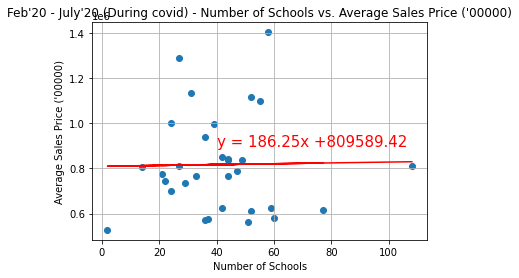

In [19]:
x_values = new_covid_merged_lga_school["School Count"]
y_values = new_covid_merged_lga_school["Average Sales Price"]
create_linear_regression_plot(x_values, y_values, "Number of Schools", "Average Sales Price ('00000)", "Feb'20 - July'20", "During", (40,900000), ylim=None)

Similar to the pre-covid linear regression model, the model above also shows no correlation between the number of schools and the average sales prices of houses. This means that the change in house prices/value in a particular LGA is not affected by the number of schools in that area. The average sales price is most likely not a good indicator of LGA popularity as sale prices in various LGAs could differ significantly due to the skewed market prices of "blue chip suburbs".

The r-squared is: 0.5134316588658595
The correlation between both factors is 0.72


[&lt;matplotlib.lines.Line2D at 0x235b3d1e0f0&gt;]

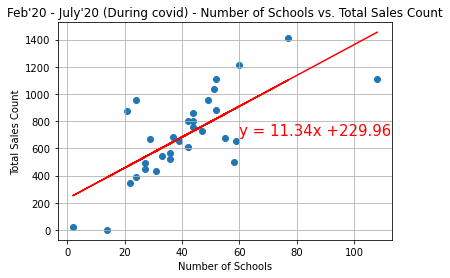

In [20]:
x_values = new_covid_merged_lga_school["School Count"]
y_values = new_covid_merged_lga_school["Sales Count"]
create_linear_regression_plot(x_values, y_values, "Number of Schools", "Total Sales Count", "Feb'20 - July'20", "During", (60,700), ylim=None)

The linear regression model above shows a strong positive correlation between the number of schools and the total sales count. This means that the higher the number of schools in any given LGA, there is a higher total sales count for that LGA. This suggests that even during COVID-19, buyers' house buying decisions are still affected by the proximity of schools within their residence.